# PS2-1 Logistic Regression: Training stability

In [1]:
import src.util as util
import numpy as np

In [2]:
ds1a_path = './data/ds1_a.csv'
ds1b_path = './data/ds1_b.csv'
ds1a_x, ds1a_y = util.load_csv(ds1a_path, add_intercept=True)
ds1b_x, ds1b_y = util.load_csv(ds1b_path, add_intercept=True)

### (a) Difference in training process on dataset $A$ and $B$.

The logistic regression model cannot converge on dataset $B$ in finite iterations.

### (b) Investigate the reason.

Train the model on $A$ and plot the result first.

In [3]:
def calc_grad(X, Y, theta):
    """Compute the gradient of the loss with respect to theta."""
    m, n = X.shape

    margins = Y * X.dot(theta)
    probs = 1. / (1 + np.exp(margins))
    grad = -(1./m) * (X.T.dot(probs * Y))

    return grad


def logistic_regression(X, Y):
    """Train a logistic regression model."""
    m, n = X.shape
    theta = np.zeros(n)
    learning_rate = 10

    i = 0
    while True:
        i += 1
        prev_theta = theta
        grad = calc_grad(X, Y, theta)
        theta = theta - learning_rate * grad
        if i % 10000 == 0:
            print('Finished %d iterations' % i)
        if np.linalg.norm(prev_theta - theta) < 1e-15:
            print('Converged in %d iterations' % i)
            break
    return theta    # return final theta

In [4]:
ds1a_theta = logistic_regression(ds1a_x, ds1a_y)

Finished 10000 iterations
Finished 20000 iterations
Finished 30000 iterations
Converged in 30387 iterations


In [5]:
ds1a_y

array([-1.,  1., -1., -1.,  1.,  1., -1.,  1., -1., -1.,  1., -1., -1.,
       -1., -1., -1., -1.,  1.,  1.,  1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1.,  1., -1.,  1., -1., -1.,  1.,  1.,  1., -1.,
        1.,  1., -1.,  1.,  1., -1., -1., -1.,  1., -1.,  1.,  1.,  1.,
       -1., -1., -1.,  1.,  1.,  1., -1.,  1., -1., -1., -1., -1.,  1.,
       -1., -1., -1.,  1.,  1.,  1.,  1., -1., -1., -1.,  1.,  1.,  1.,
        1., -1., -1., -1., -1.,  1., -1.,  1.,  1., -1.,  1.,  1.,  1.,
       -1.,  1.,  1.,  1.,  1., -1.,  1.,  1., -1.])

In [6]:
ds1a_y_plot = np.where(ds1a_y == -1, 0, ds1a_y) # replace -1 with zero for plot

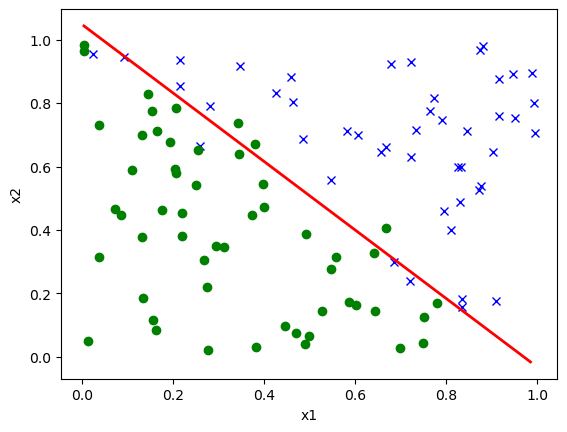

In [7]:
util.plot(ds1a_x, ds1a_y_plot, ds1a_theta, './output/ds1a.png')

Then plot $B$.

In [8]:
ds1b_y_plot = np.where(ds1b_y == -1, 0, ds1b_y) # replace -1 with zero for plot

/home/lpy/code/workspace/Tutorials&Courses/CS229_Machine_Learning_2018_ProblemSets/PS2/src/util.py:94: RuntimeWarning: invalid value encountered in scalar divide
  x2 = -(theta[0] / theta[2] * correction + theta[1] / theta[2] * x1)


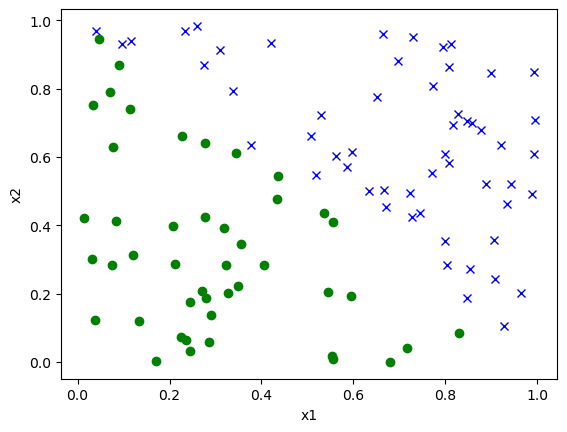

In [9]:
util.plot(ds1b_x, ds1b_y_plot, np.zeros(3), './output/ds1b.png')

It can be observed that different from $A$, data points of $B$ are fully linear seperatable. Intuitionally, this means there are several hyperplanes seperating the data space. Therefore, the algorithm cannot find an optimal hyperplane and the model cannot converge.

Next, we prove this intuition more formally. To be consistent with the lecture, we first replace $-1$ with $0$ in labels. 

For gradient descent, we want to minimize the loss $J(\theta)$, and the update rule is

$$\theta := \theta - \alpha \nabla_\theta J(\theta)$$

where $\alpha$ is the learning rate and $\nabla_\theta J(\theta)$ is the gradient of the loss function. 

For logistic regression, the loss function is

$$J(\theta) = -\frac{1}{m}\sum_{i=1}^m \left[y^{(i)}\ln h_\theta(x^{(i)}) + (1-y^{(i)})\ln(1-h_\theta(x^{(i)}))\right]$$

where hypothesis function $h_\theta(x)=\frac{1}{1+\exp{(-\theta^Tx)}}$.

Since 
1) $h(x)=\frac{1}{1+\exp{(-x)}}$ and $\ln(x)$ increase monotonically w.r.t. $x$
2) $\lim_{x\rightarrow+\infty}h(x)=1, \lim_{x\rightarrow-\infty}h(x)=0$

ideally we can simply minimize $J(\theta)$ by pushing $\theta^Tx \rightarrow +\infty$ for samples with label $1$ and $\theta^Tx \rightarrow -\infty$ for samples with label $0$.

Now assume that the model has found a hyperplane seperating the two classes perfectly (i.e., training accuracy has achieved 100%). Formally, that means

$$y^{(i)} = 1 \Longleftrightarrow h_\theta(x^{(i)}) > 0.5 \Longleftrightarrow \theta^Tx^{(i)} > 0$$
$$y^{(i)} = 0 \Longleftrightarrow h_\theta(x^{(i)}) \le 0.5 \Longleftrightarrow \theta^Tx^{(i)} \le 0$$

Therefore, the model can always obtain a lower loss just by multiplicating $\theta$ by a positive constant $c>1$ 
$$\theta := c \theta$$
This will **not** change the decision boundary, but will push $\theta^Tx$ further away from $0$ for **all** samples, thus reducing the loss.

For data that is not fully linearly separable, this will not happen because there are false positives and false negatives. These false predictions will give the model a more powerful punishment if it tries to push $\theta^Tx$ further away from $0$.

In summary, the asymptotic behavior of sigmoid and no limitation on $||\theta||$ result in unconvergence of logistic regression model on fully linearly separable data.

> This webpage explains the concept of complete separation in logistic regression: [Understanding Complete Separation for Logistic Regression](https://stats.stackexchange.com/questions/224863/understanding-complete-separation-for-logistic-regression).

### (c) Deal with the problem.

#### i. Using a different constant learning rate.

This will not work since $||\theta||$ can still be pushed to infinity.

#### ii. Decreasing the learning rate over time.

In [10]:
def logistic_regression_lr_schedule(X, Y):
    """Train a logistic regression model."""
    m, n = X.shape
    theta = np.zeros(n)
    init_learning_rate = 10

    i = 0
    while True:
        i += 1
        learning_rate = init_learning_rate / i**2  # lr schedule: 1/i^2
        prev_theta = theta
        grad = calc_grad(X, Y, theta)
        theta = theta - learning_rate * grad
        if i % 10000 == 0:
            print('Finished %d iterations' % i)
            # print(np.linalg.norm(prev_theta - theta))
        if np.linalg.norm(prev_theta - theta) < 1e-15:
            print('Converged in %d iterations' % i)
            break
    return theta    # return final theta

In [11]:
ds1b_theta = logistic_regression_lr_schedule(ds1b_x, ds1b_y)

Finished 10000 iterations
Finished 20000 iterations
Finished 30000 iterations
Finished 40000 iterations
Finished 50000 iterations
Finished 60000 iterations
Finished 70000 iterations
Finished 80000 iterations
Finished 90000 iterations
Finished 100000 iterations
Finished 110000 iterations
Finished 120000 iterations
Finished 130000 iterations
Finished 140000 iterations
Finished 150000 iterations
Finished 160000 iterations
Finished 170000 iterations
Finished 180000 iterations
Finished 190000 iterations
Finished 200000 iterations
Finished 210000 iterations
Finished 220000 iterations
Finished 230000 iterations
Finished 240000 iterations
Finished 250000 iterations
Finished 260000 iterations
Finished 270000 iterations
Finished 280000 iterations
Finished 290000 iterations
Finished 300000 iterations
Finished 310000 iterations
Finished 320000 iterations
Finished 330000 iterations
Finished 340000 iterations
Finished 350000 iterations
Finished 360000 iterations
Finished 370000 iterations
Finished 3

In [12]:
ds1b_theta

array([-0.57254056,  1.19185781,  0.89622036])

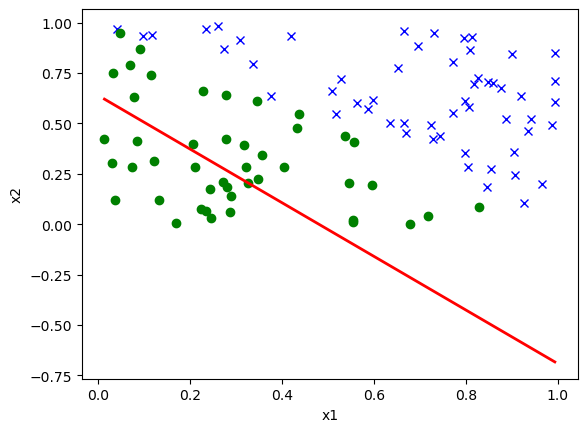

In [13]:
util.plot(ds1b_x, ds1b_y_plot, ds1b_theta, './output/ds1b_converged.png')

Learning rate schedule helps a little but leads to underfitting since the learning rate decays too fast.

#### iii. Linear scaling of the input features.

In [14]:
ds1b_x_scaled = ds1b_x.copy()
ds1b_x_scaled[:, 1:] = (ds1b_x[:, 1:] - np.mean(ds1b_x[:, 1:], axis=0)) / np.std(ds1b_x[:, 1:], axis=0)  # standardize features

In [15]:
# ds1b_theta = logistic_regression(ds1b_x_scaled, ds1b_y) # not converged

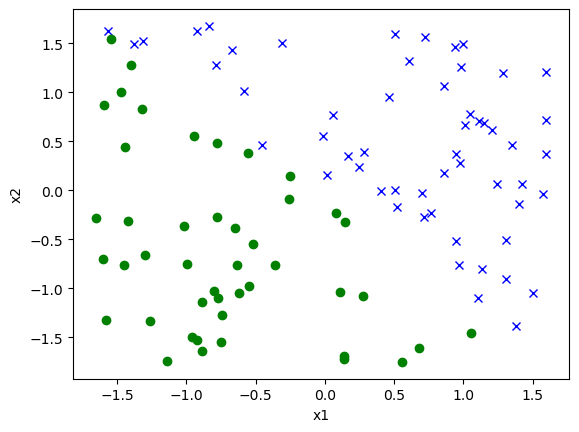

In [16]:
util.plot(ds1b_x_scaled, ds1b_y_plot, np.zeros(3), './output/ds1b_standardized.png')

Model does not converge since data is still linear seperatable after linear scaling.

#### iv. Adding a regularization term.

In [17]:
def logistic_regression_regularization(X, Y):
    """Train a logistic regression model."""
    m, n = X.shape
    theta = np.zeros(n)
    learning_rate = 10

    i = 0
    while True:
        i += 1
        prev_theta = theta
        grad = calc_grad(X, Y, theta)
        theta = theta - learning_rate * (grad + 0.001 * theta)  # adding regularization term
        if i % 10000 == 0:
            print('Finished %d iterations' % i)
            # print(np.linalg.norm(prev_theta - theta))
        if np.linalg.norm(prev_theta - theta) < 1e-15:
            print('Converged in %d iterations' % i)
            break
    return theta    # return final theta

In [19]:
ds1b_theta = logistic_regression_regularization(ds1b_x, ds1b_y)

Converged in 1200 iterations


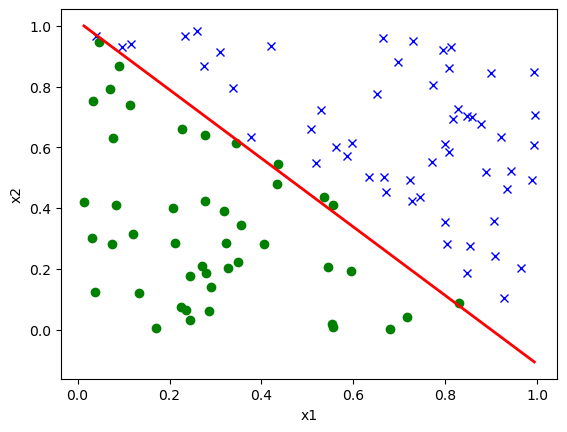

In [20]:
util.plot(ds1b_x, ds1b_y_plot, ds1b_theta, './output/ds1b_regularization.png')

Regularization helps since it prevents the model from having parameters that are too large.

#### v. Adding zero-mean Gaussian noise to the training data or labels.

Add noise to the training data.

In [26]:
ds1b_x_noised = ds1b_x.copy()
ds1b_x_noised[:, 1:] += np.random.normal(0, 0.05, ds1b_x_noised[:, 1:].shape)  # add Gaussian noise

In [27]:
ds1b_theta = logistic_regression(ds1b_x_noised, ds1b_y)

Finished 10000 iterations
Finished 20000 iterations
Finished 30000 iterations
Finished 40000 iterations
Finished 50000 iterations
Finished 60000 iterations
Finished 70000 iterations
Converged in 70523 iterations


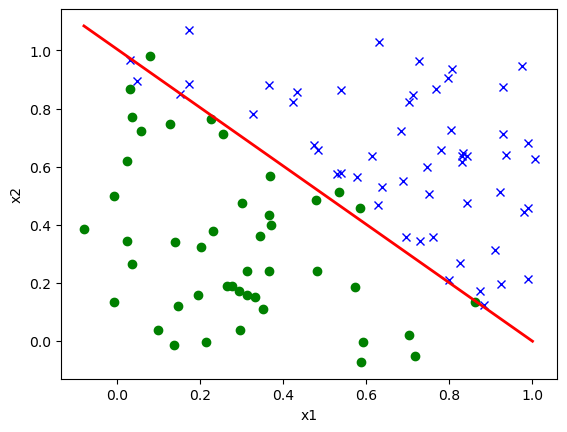

In [28]:
util.plot(ds1b_x_noised, ds1b_y_plot, ds1b_theta, './output/ds1b_noisy_data.png')

Add noise to the training label.

In [31]:
ds1b_y_noised = ds1b_y.copy()
ds1b_y_noised += np.random.normal(0, 0.01, ds1b_y_noised.shape)  # add Gaussian noise

In [32]:
ds1b_y_noised

array([-0.98975955, -1.0002059 ,  0.98553896, -0.99469401, -0.99051475,
       -0.99537526, -0.99083075, -1.00494114,  0.99655166, -1.00794334,
        0.99672357, -0.99149274, -1.01392896,  0.99720179, -1.00897773,
       -1.00297699,  0.99415792,  1.0054144 , -1.01932025, -0.98490668,
       -0.98649396, -1.01803279,  0.98944292,  1.01875365, -0.99245   ,
       -1.01536483,  0.99896556,  1.01069851, -1.00489445,  0.98941687,
        1.00546563,  1.00031136,  0.99050485,  1.0003907 ,  0.99485504,
        1.00338774,  1.0043127 , -0.99748182, -1.0002769 ,  0.99253992,
        0.97863237, -0.98683649,  0.99476511,  1.00483188,  0.98573639,
        1.00976133, -0.98950892, -1.0101542 , -0.99308989, -0.9841326 ,
        1.00662591, -0.99072129, -0.99599088,  0.9840225 ,  0.99813109,
        0.99387464,  0.99373034,  0.98740421, -1.00290902,  0.98362624,
        0.99162203,  0.99007578,  1.01728371,  1.00365322, -1.00689577,
       -1.00792208, -0.99446967, -0.98560903,  0.99230077,  0.98

In [34]:
# ds1b_theta = logistic_regression(ds1b_x, ds1b_y_noised) # not converged

Add noise to training data works since it breaks the linear separability of the data.

### (c) SVM with hinge loss does not suffer from complete separation problem.

The hinge loss is defined as:

$$L(y^{(i)},x^{(i)}) = \max(0, 1-y^{(i)}h_\theta(x^{(i)}))$$

$h_\theta(x^{(i)}), y^{(i)} \in \{-1,1\}$.

Therefore, when one perfect decision boundary is found, the total loss will achieve the minimum $0$ (where the gradient becomes zero) and optimization stops.